In [6]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Input



In [7]:
imageList = tf.data.Dataset.list_files(os.path.join('data4', '*.png'), 
                                   shuffle = False)
textList = tf.data.Dataset.list_files(os.path.join('data4', '*.txt'),
                                      shuffle = False)


imagecount = len(imageList)
print(imagecount)
textcount = len(textList)
print(textcount)

6608
6608


In [9]:
def preprocess(filepath):
    # this is the function that will process all the images that are in the image list for basic conversion

    #read image
    img = tf.io.read_file(filepath)
    #load image
    img = tf.io.decode_png(img, channels=3)

    #img = tf.image.resize(img, [586, 826])
    #scaled the image to be 0-1
    img = img / 255

    #img = tf.image.central_crop(image=img, central_fraction=0.80)

    #img = tf.image.rgb_to_grayscale(img)

    #img = tf.expand_dims(img, axis=0)

    #img = tf.image.adjust_brightness(img, -0.25)
    #img = tf.image.adjust_contrast(img, 5)
    #img = tf.image.adjust_gamma(img, 5, 5)

    return img

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


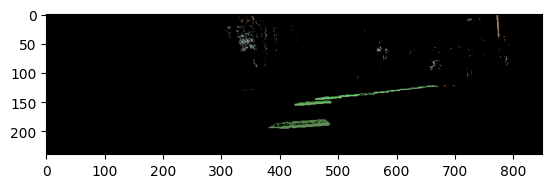

In [10]:
imageList = imageList.map(preprocess)
plt.imshow(imageList.as_numpy_iterator().next(), cmap='gray')
print(imageList.as_numpy_iterator().next())


In [12]:
def preprocess_text(filepath):

    key = tf.io.read_file(filepath)

    if key == 'up arrow\r\n':
        return [1,0,0,0]
    if key == 'down arrow\r\n':
        return [0,1,0,0]
    if key == 'left arrow\r\n':
        return [0,0,1,0]
    if key == 'right arrow\r\n':
        return [0,0,0,1]
    if key == 'left arrow,up arrow\r\n':
        return [1,0,1,0]
    if key == 'left arrow,down arrow\r\n':
        return [0,1,1,0]
    if key == 'right arrow,up arrow\r\n':
        return [1,0,0,1]
    if key == 'right arrow,down arrow\r\n':
        return [0,1,0,1]
    else:
        return [0,0,0,0]
    return key 

In [13]:
def wrap_array(x1,x2,x3,x4):
    return tf.expand_dims([x1,x2,x3,x4], axis = 0)

In [14]:
textList = textList.map(lambda x: tf.py_function(preprocess_text, [x], ([tf.int16, tf.int16, tf.int16, tf.int16,])))
textList = textList.map(wrap_array)

normalization_layer = tf.keras.layers.Rescaling(1./255)


In [15]:
val_size = int(0.2 * imagecount)

train_image = imageList.skip(val_size)
train_text = textList.skip(val_size)
val_image = imageList.take(val_size)
val_text = textList.take(val_size)

print(len(val_image), len(train_image))

1321 5287


In [16]:
train_ds = tf.data.Dataset.zip((train_image, train_text))
val_ds = tf.data.Dataset.zip((val_image, val_text))

#train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [17]:
def unwrap(x, y):
    return x, tf.squeeze(y)

In [18]:
AUTOTUNE = tf.data.AUTOTUNE


def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(8)
  ds = ds.prefetch(buffer_size = AUTOTUNE)
  ds = ds.map(unwrap)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [20]:
#tf.reshape(train_ds, [586, 826])

model = Sequential()

print(imageList.as_numpy_iterator().next().shape)

#model.add(keras.Input(shape=((586, 826, 3))))

model.add(Conv2D(64,  #filters
                  5,  #kernel size
                  strides = (3,3),   #reducing the compression so its not 400 million parameters lkmfaoooo
                activation = 'relu',  #activation type
                input_shape =((240, 850, 3)
                )))  #input shape (batch, shape as seen above)#

model.add(BatchNormalization())

model.add(MaxPooling2D())

model.add(Conv2D(128, 4, 
                 strides = (3,3),
                   activation='relu'))

model.add(BatchNormalization())


model.add(Conv2D(128, 3, 
                 strides = (3,3),
                   activation='relu'))


model.add(BatchNormalization())

model.add(MaxPooling2D())

model.add(Conv2D(256, 2, 
                 strides = (3,3),
                   activation='relu'))


model.add(BatchNormalization())



model.add(GlobalAveragePooling2D())

model.add(Flatten())

model.add(Dense(4, activation='softmax'))

(240, 850, 3)


In [21]:

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 79, 282, 64)       4864      
                                                                 
 batch_normalization_4 (Batc  (None, 79, 282, 64)      256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 39, 141, 64)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 46, 128)       131200    
                                                                 
 batch_normalization_5 (Batc  (None, 12, 46, 128)      512       
 hNormalization)                                                 
                                                      

In [22]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=[tf.keras.metrics.CategoricalAccuracy()])


In [23]:
model.fit(train_ds, validation_data=val_ds, epochs=25,
          # steps_per_epoch=(250)
          )

Epoch 1/25
661/661 [==============================] - 111s 161ms/step - loss: 1.7149 - categorical_accuracy: 0.6546 - val_loss: 1.8330 - val_categorical_accuracy: 0.5920
Epoch 2/25
661/661 [==============================] - 107s 162ms/step - loss: 1.6578 - categorical_accuracy: 0.7416 - val_loss: 1.7703 - val_categorical_accuracy: 0.6465
Epoch 3/25
661/661 [==============================] - 106s 161ms/step - loss: 1.6494 - categorical_accuracy: 0.7360 - val_loss: 1.7371 - val_categorical_accuracy: 0.6980
Epoch 4/25
661/661 [==============================] - 107s 161ms/step - loss: 1.6413 - categorical_accuracy: 0.7560 - val_loss: 1.7312 - val_categorical_accuracy: 0.6699
Epoch 5/25
661/661 [==============================] - 109s 164ms/step - loss: 1.6307 - categorical_accuracy: 0.7638 - val_loss: 1.7417 - val_categorical_accuracy: 0.6813
Epoch 6/25
661/661 [==============================] - 109s 165ms/step - loss: 1.6283 - categorical_accuracy: 0.7643 - val_loss: 1.8151 - val_categoric

In [24]:
test_loss, test_acc = model.evaluate(val_ds)
print(f"test accuracy -> {test_acc}, test loss -> {test_loss}")


166/166 [==============================] - 6s 39ms/step - loss: 1.7268 - categorical_accuracy: 0.6472
test accuracy -> 0.6472369432449341, test loss -> 1.7268157005310059


In [25]:
model.save('modeltype4.model')

INFO:tensorflow:Assets written to: modeltype4.model\assets


INFO:tensorflow:Assets written to: modeltype4.model\assets
